# Results

This notebook can be used to visualize the results stored in your Azure status table.

In [1]:
from pathlib import Path

config=Path('..') / '..' / 'output' / 'scripts' / 'confs' / 'aml_search.yaml'

from archai.common.store import ArchaiStore
from archai.common.config import Config

config = Config(str(config))
aml_config = config['aml']
metric_key = config['training'].get('metric_key')
connection_str = aml_config['connection_str']
experiment_name = aml_config['experiment_name']
storage_account_name, storage_account_key = ArchaiStore.parse_connection_string(connection_str)
store = ArchaiStore(storage_account_name, storage_account_key, table_name=experiment_name)

config loaded from:  d:\git\microsoft\archai\archai\tasks\face_segmentation\output\scripts\confs\aml_search.yaml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

def calc_frontier(points):
    pareto = []
    pareto += [0]
    p1 = points[0]
    for i in range(1, len(points)):
        p2 = points[i]
        if p2[1] > p1[1]:
            pareto += [i]
            p1 = p2

    return pareto

def scatter_plot(status, xkey, ykey, xlabel, ylabel, title, xlimit=None, ylimit=None,):
    points = []
    max_iteration = 0
    for e in status:
        iteration = e['iteration'] if 'iteration' in e else 0
        if iteration > max_iteration:
            max_iteration = iteration
        if xkey in e and ykey in e:
            points += [[float(e[xkey]), float(e[ykey]), iteration]]
    
    if len(points):
        points = np.array(points)
        sorted = points[points[:,0].argsort()]
        pareto = calc_frontier(sorted)
        points = list(sorted)
        pareto.reverse()
        top_most = []
        for i in pareto:
            x,  y, _ = points[i]
            top_most += [[x, y, max_iteration + 3]]
            del points[i]
        for p in top_most:
            points += [p]

        df = pd.DataFrame(points, columns=[xlabel, ylabel, 'iteration'])
        plt.style.use('dark_background')
        ax = df.plot.scatter(x=xlabel, y=ylabel, c='iteration', colormap='viridis')
        if xlimit is not None:
            ax.set_xlim(xlimit)
        if ylimit is not None:
            ax.set_ylim(ylimit)
        ax.set_title(title)
        # save the plot to a png image
        fig = ax.get_figure()
        fig.savefig(title + '.png')
    else:
        print("No points found for {title}")


In [3]:
def get_iteration(iteration):
    status = []
    for e in store.get_all_status_entities():
        if 'iteration' in e and iteration >= int(e['iteration']):
            status += [e]
    print(f"loaded {len(status)} entities")    
    return status

loaded 705 entities


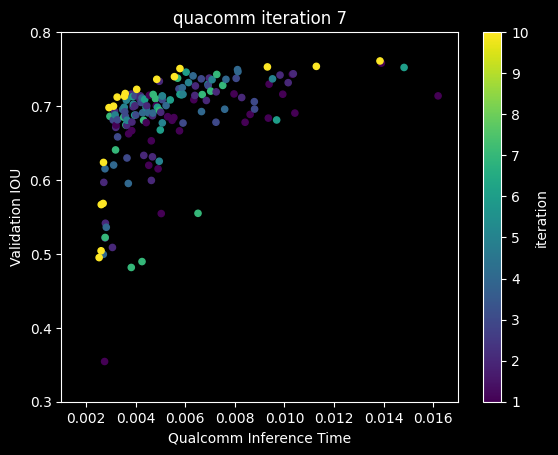

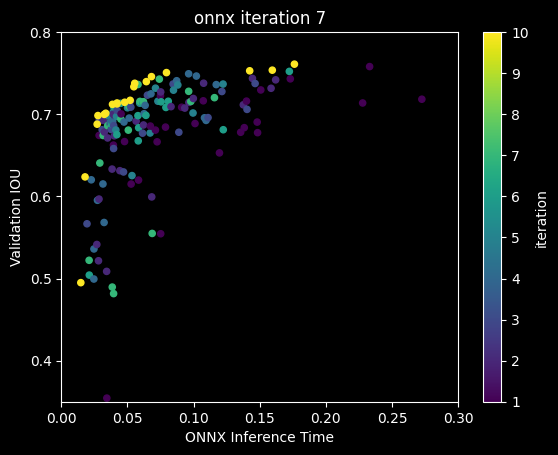

In [6]:
i = 7
status = get_iteration(i)
scatter_plot(status, 'mean', 'val_iou', 'Qualcomm Inference Time', 'Validation IOU', f'quacomm iteration {i}', (0.001,0.017), (0.3,0.8))
scatter_plot(status, 'onnx_latency', 'val_iou', 'ONNX Inference Time', 'Validation IOU', f'onnx iteration {i}', (0, 0.30), (0.35, 0.80))